# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [125]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
import random

# Прогресс бар
from tqdm import tqdm

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [341]:
class Perceptron:
    def __init__(self, iterations=100, learning_rate = 1, key=True):
        self.w = None
        self.iters = iterations
        self.lr = learning_rate
        self.key = True
        
    def h(self, x):
        temp = np.sign(np.sum(x*self.w))
        return temp
            

    def fit(self, X, y):
        X = np.hstack((np.full((X.shape[0], 1), 1), X))
        temp = 1/(X.shape[1]+1)**0.5
        self.w = np.random.uniform(-temp, temp, size=X.shape[1])
        for _ in range(self.iters):
            for i in range(X.shape[0]):
                if self.h(X[i]) != y[i]:
                    self.w += y[i] * X[i] * self.lr

    def predict(self, X):
        X = np.hstack((np.full((X.shape[0], 1), 1), X))
        y = np.zeros(len(X))
        for i in range(len(X)):
            y[i] = self.h(X[i])
        return y

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

In [127]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")

    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.02it/s]


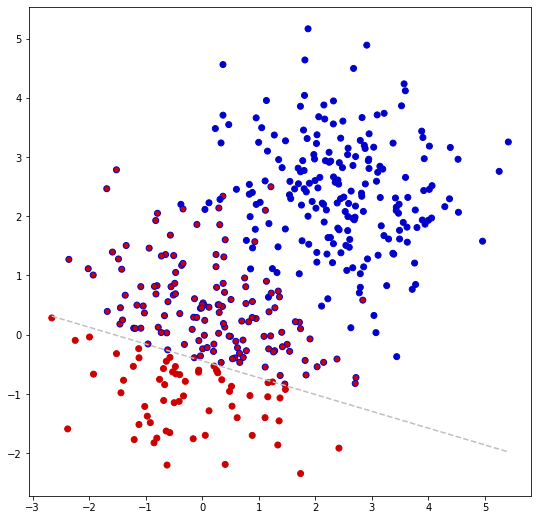

In [337]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron(iterations=1000)
c.fit(X, true_labels)
y_pred = np.array(c.predict(X))
y_pred[y_pred == -1] = 0
visualize(X, true_labels, y_pred, c.w)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 385.99it/s]


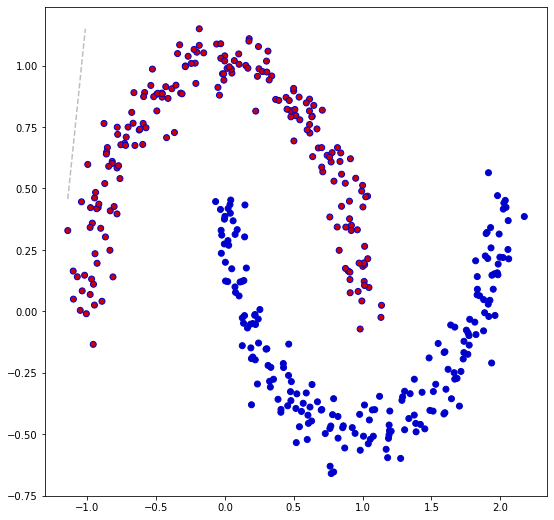

In [340]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron(iterations=1000)
c.fit(X, true_labels)
y_pred = np.array(c.predict(X))
y_pred[y_pred == -1] = 0
visualize(X, true_labels, y_pred, c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

Реализуем перцептрон с карманом.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [334]:
class PerceptronBest:
    def __init__(self, iterations=100, learning_rate = 1):
        self.w = None
        self.iters = iterations
        self.lr = learning_rate
        
    def h(self, X):
        y = np.sign(np.sum(X*self.w, axis=1))
#         y[y == -1] = 0
        return y

    def fit(self, X, y):
        X = np.hstack((np.full((X.shape[0], 1), 1), X))
        temp = 1/(X.shape[1]+1)**0.5
        self.w = np.random.uniform(-temp, temp, size=X.shape[1])
        self.best_w = self.w
        score_temp = np.mean(y == self.predict(X[:,1:]))
        for _ in range(self.iters):
            self.w = self.best_w
            for i in range(X.shape[0]):
                if self.h(X)[i] != y[i]:
                    self.w += y[i] * X[i] * self.lr
                
            if np.mean(y == self.predict(X[:,1:])) > score_temp:
                self.best_w = self.w
                
        self.w = self.best_w

    def predict(self, X):
        X = np.hstack((np.full((X.shape[0], 1), 1), X))
        y = self.h(X)
        return y

X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

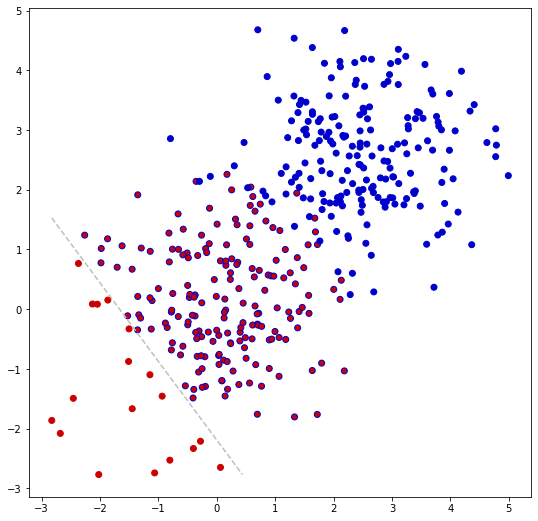

In [345]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest(iterations=1000)
c.fit(X, true_labels)
y_pred = np.array(c.predict(X))
y_pred[y_pred == -1] = 0
visualize(X, true_labels, y_pred, c.w)

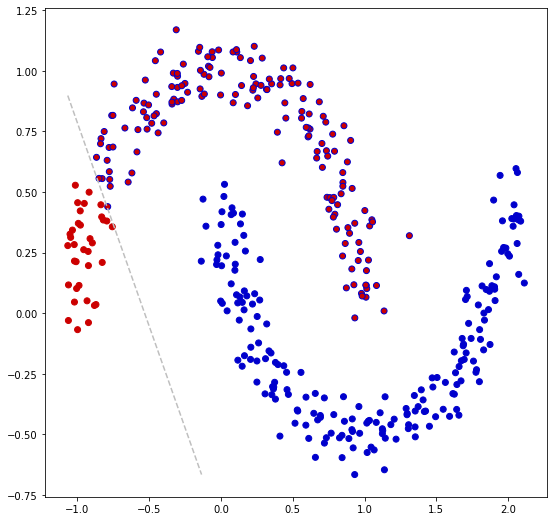

In [348]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
y_pred = np.array(c.predict(X))
y_pred[y_pred == -1] = 0
visualize(X, true_labels, y_pred, c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [385]:
def transform_images(images):
    res = np.zeros((images.shape[0], 2))

    out_im1 = np.zeros((6, 6))
    out_im2 = np.zeros((6, 6))

    kernel1 = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]])/3
    kernel2 = np.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]])/3
    
    for k in range(len(images)):
        for i in range(1, 7):
            for j in range(1, 7):
#                 print(k,i,j,' and ',  i-1, i+2, j-1,j+2)
                out_im1[i-1,j-1] = np.sum(images[k,i-1:i+2, j-1:j+2] * kernel1)
                out_im2[i-1,j-1] = np.sum(images[k,i-1:i+2, j-1:j+2] * kernel2)
        
        res[k,0] = np.mean(out_im1)
        res[k,1] = np.mean(out_im2)
    return res


def get_digits(train_image_ids, test_image_ids):
    data = datasets.load_digits()
    images_train, labels_train = data.images[train_image_ids[
        'ImageId'].values], data.target[train_image_ids['ImageId'].values]
    images_test, labels_test = data.images[test_image_ids[
        'ImageId'].values], data.target[test_image_ids['ImageId'].values]
    return images_train, labels_train, images_test, labels_test


def get_digits_by_mask(images, labels, y0, y1):
    mask = np.logical_or(labels == y0, labels == y1)
    
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    return images, labels, mask


def get_x_y(train_image_ids, test_image_ids, y0=1, y1=5):
    X_train, y_train, X_test, y_test = get_digits(train_image_ids,
                                                  test_image_ids)

    X_train, y_train, _ = get_digits_by_mask(X_train, y_train, y0, y1)
    X_train = transform_images(X_train)

    X_test, y_test, IDs = get_digits_by_mask(X_test, y_test, y0, y1)
    X_test = transform_images(X_test)

    return X_train, y_train, X_test, y_test, IDs

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [386]:
train_ids, test_ids = pd.read_csv("x_digits_train.csv"), pd.read_csv("x_digits_test.csv")
X_train, y_train, X_test, y_test, IDs = get_x_y(train_ids, test_ids)

y_train[y_train == 1] = -1
y_train[y_train == 5] = 1

y_test[y_test == 1] = -1
y_test[y_test == 5] = 1

In [359]:
c = Perceptron(iterations=1000, learning_rate=1, key=False)
c.fit(X_train, y_train)
y_pred = c.predict(X_test) 
print("Accuracy:", np.mean(y_pred == y_test))

Accuracy: 1.0


In [393]:
c = PerceptronBest(iterations=1000)
c.fit(X_train, y_train)
y_pred = c.predict(X_test) 
print("Accuracy:", np.mean(y_pred == y_test))

Accuracy: 0.8082191780821918


In [396]:
submission = pd.DataFrame(columns = ["Id", "Expected"])
y_pred[y_pred == 1] = 5
y_pred[y_pred == -1] = 1
submission["Id"] = test_ids['Id']
submission["Expected"] = list(map(int, y_pred))
submission.to_csv('submission.csv', index=False)

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [357]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X_train, y_train, X_test, y_test = get_x_y(train_ids, test_ids, y0, y1)
    c = Perceptron(iterations=200)
    
    print(y0,y1)
    
    y_train[y_train == y0] = -1
    y_train[y_train == y1] = 1

    y_test[y_test == y0] = -1
    y_test[y_test == y1] = 1
    
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

0 1


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X_train, y_train, X_test, y_test = get_x_y(train_ids, test_ids, y0, y1)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))